In [1]:
import pandas as pd
import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as axes3d
import os

import torch
from torch import nn
from torch.utils.data import *
from torch.optim import *
from fastai.model import *
from fastai.column_data import *
from fastai.dataloader import *
from torch.utils.data import DataLoader as torch_dl

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

%matplotlib inline

In [2]:
def to_gauss(x): return np.sqrt(2)*erfinv(x) 

def normalize(data, exclude=None):
#     norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    norm_cols = ['x', 'y', 'z']
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()
        uniform = np.linspace(start=-0.99, stop=0.99, num=n)
        normal = to_gauss(uniform)
        normalized_col = pd.Series(index=sorted_idx, data=normal)
        data[col] = normalized_col
    return data

def inputSwapNoise(arr, p):
    ### Takes a numpy array and swaps a row of each 
    ### feature with another value from the same column with probability p

    n, m = arr.shape
    idx = range(n)
    swap_n = round(n*p)
    for i in range(m):
        col_vals = np.random.permutation(arr[:, i])
        swap_idx = np.random.choice(idx, size= swap_n)
        arr[swap_idx, i] = np.random.choice(col_vals, size = swap_n)
    return arr

In [3]:
class AEDataset(Dataset):
    ### AutoEncoder dataset class
    ### Takes denoising function
    ### Some kind of denoising function is recommended
    ### if hidden layer sizes are smaller then input dimension
    ### since there is risk of finding identity
    
    def __init__(self, arr, denoise_func=None, p=None):
        self.x = arr.copy()
        if denoise_func: self.x_tilde = denoise_func(arr.copy(), p)
        else: self.x_tilde = arr.copy()
        self.is_reg = False # not regression
        self.is_multi=False # not multi classification
        
    def __len__(self): return self.x.shape[0]
    
    def __getitem__(self, idx): return torch.from_numpy(self.x_tilde[idx]).float(), torch.from_numpy(self.x[idx]).float()

In [4]:
class AEModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, torch_dl(trn_ds, batch_size=bs, shuffle=True, num_workers=1)
                         ,torch_dl(val_ds, batch_size=128, shuffle=True, num_workers=1), test_ds)
    
    @classmethod
    def from_arrays(cls, path, arr, val_idxs, trn_idxs, denoise_func, p, bs, test_ds=None):
        arr_trn = arr[val_idxs]
        arr_val = arr[trn_idxs]
        return cls(path, AEDataset(arr_trn, denoise_func, p),
                    AEDataset(arr_val, denoise_func, p), bs, test_ds=None)

In [87]:
class AutoEncoder(nn.Module):
    ### After training calling compute_activations 
    ### will allow to get activations (new features) of the input data
    
    ### You can get features at any point of training by calling
    ### get features but if couple tries will be made
    ### it's more efficient to set self.compute_activations = False
    ### after intermediate calls of get_features
    
    def __init__(self, layers, compute_activations = False):
        super().__init__()
        self.layers = layers
        self.compute_activations = compute_activations
        for i in range(len(layers)-1):
            setattr(self, f"fc{i}", nn.Linear(layers[i], layers[i + 1]))
        self.save = None
        
    def forward(self, x):
        self.activations = []
        for i in range(len(self.layers)-1):
            dotprod = getattr(self, f"fc{i}")
            x = dotprod(x)
            if self.compute_activations:
                self.activations += [x]
        return x

    def get_activations(self, x):
        self.forward(x)
        return self.activations
        
    def get_features(self,x):
        self.compute_activations = True
        self.get_activations(x)
        features = torch.cat([act.data for act in self.activations], 1)
        return features

In [6]:
# say we have a straight line function
# y = mx + c
# let m = 5, c = 20, x in {0, 100}
x = torch.FloatTensor(25).random_(0, 100)

In [7]:
y = 5 * x + 20

In [8]:
print(x)
print(y)


 78
 86
 17
 41
 37
 21
 56
  6
 96
 81
 78
 86
 15
 36
 13
 35
 65
  6
 17
 81
 62
 65
 93
 13
 97
[torch.FloatTensor of size 25]


 410
 450
 105
 225
 205
 125
 300
  50
 500
 425
 410
 450
  95
 200
  85
 195
 345
  50
 105
 425
 330
 345
 485
  85
 505
[torch.FloatTensor of size 25]



In [9]:
X = x.cpu().numpy()
Y = y.cpu().numpy()

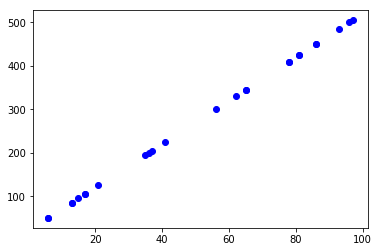

In [10]:
plt.plot(X,Y, 'bo')
plt.show()

In [11]:
# now read 1 event
path_to_train = "../data/train"
event_prefix = "event000001000"
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [12]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [13]:
hits.shape

(120939, 7)

In [14]:
hits_7_2_1 = hits[hits.volume_id==7][hits.layer_id==2][hits.module_id==1]

/home/watts/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [15]:
hits_7_2_1.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [16]:
hits_7_2_1.shape

(21, 7)

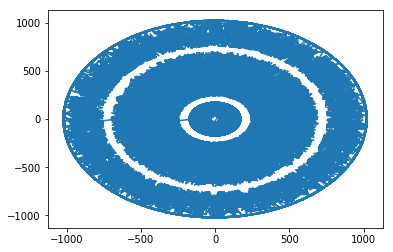

In [17]:
plt.plot(hits.x, hits.y)
plt.show()

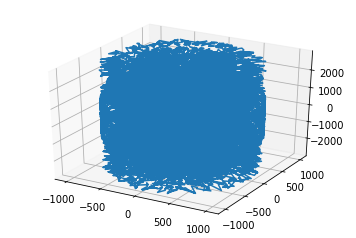

In [18]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(hits.x, hits.y, hits.z)
plt.show()

In [19]:
hits1 = hits_7_2_1

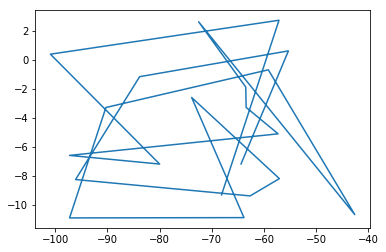

In [20]:
plt.plot(hits1.x, hits1.y)
plt.show()

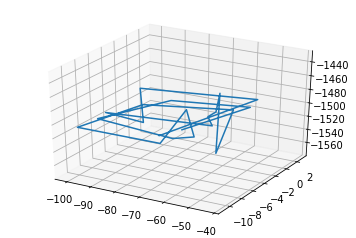

In [21]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(hits1.x, hits1.y, hits1.z)
plt.show()

In [22]:
hits.shape

(120939, 7)

In [23]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [24]:
hits['vlm_id'] = hits['volume_id'].astype('str') + '_' + hits['layer_id'].astype('str') + '_' + hits['module_id'].astype('str')

In [25]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,vlm_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,7_2_1
1,2,-55.336102,0.635342,-1502.5,7,2,1,7_2_1
2,3,-83.830498,-1.143010,-1502.5,7,2,1,7_2_1
3,4,-96.109100,-8.241030,-1502.5,7,2,1,7_2_1
4,5,-62.673599,-9.371200,-1502.5,7,2,1,7_2_1


In [26]:
hits.vlm_id.value_counts()

8_2_107      161
8_2_123      153
8_2_124      151
8_2_108      151
8_2_98       150
8_2_113      150
8_2_128      148
8_2_104      146
8_2_114      143
8_2_109      142
8_2_112      141
8_2_102      140
8_2_110      139
8_2_122      138
8_2_105      136
8_2_126      135
8_2_119      135
8_2_99       135
8_2_125      135
8_2_111      134
8_2_106      129
8_2_120      128
8_2_127      127
8_2_103      127
8_2_117      127
8_2_101      126
8_2_97       125
8_2_118      123
8_2_100      120
8_2_116      119
            ... 
17_2_590       1
17_2_2220      1
17_4_639       1
17_4_597       1
17_4_530       1
17_2_214       1
17_2_974       1
17_2_628       1
17_4_2813      1
17_4_2664      1
13_8_2065      1
17_4_1324      1
13_8_1988      1
16_10_90       1
17_4_2254      1
13_6_1581      1
18_6_3         1
17_4_1229      1
17_2_30        1
17_2_1808      1
17_4_874       1
17_4_2248      1
8_2_6          1
17_4_1203      1
13_8_1125      1
13_8_903       1
13_6_122       1
13_8_1372     

In [27]:
hits.vlm_id.nunique()

17471

In [28]:
hits.vlm_id.value_counts().at['8_2_107']

161

In [29]:
s = hits.vlm_id.value_counts()
hits['vlm_id_count'] = hits['vlm_id'].map(lambda x: s.at[x])

In [30]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,vlm_id,vlm_id_count
0,1,-64.409897,-7.163700,-1502.5,7,2,1,7_2_1,21
1,2,-55.336102,0.635342,-1502.5,7,2,1,7_2_1,21
2,3,-83.830498,-1.143010,-1502.5,7,2,1,7_2_1,21
3,4,-96.109100,-8.241030,-1502.5,7,2,1,7_2_1,21
4,5,-62.673599,-9.371200,-1502.5,7,2,1,7_2_1,21


In [31]:
data = hits[['x', 'y', 'z']]

In [32]:
print(data.head())
print(data.shape)

           x         y       z
0 -64.409897 -7.163700 -1502.5
1 -55.336102  0.635342 -1502.5
2 -83.830498 -1.143010 -1502.5
3 -96.109100 -8.241030 -1502.5
4 -62.673599 -9.371200 -1502.5
(120939, 3)


In [33]:
norm_data = normalize(data)

/home/watts/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [34]:
print(norm_data.head())
print(norm_data.shape)

          x         y         z
0 -0.503817 -0.066264 -1.518674
1 -0.449537 -0.003960 -1.508226
2 -0.606642 -0.022922 -1.508098
3 -0.650851 -0.074472 -1.507650
4 -0.493014 -0.082705 -1.508034
(120939, 3)


In [35]:
X = np.array(norm_data)

In [36]:
X.shape

(120939, 3)

In [37]:
# separate train, val
np.random.seed(42)
n = X.shape[0]
val_ratio = 0.3
val_idxs = np.random.permutation(range(n))[:round(n*0.3)]
trn_idxs = np.random.permutation(range(n))[round(n*0.3):]

In [38]:
sample_ds = AEDataset(X, inputSwapNoise, 0.15)

In [39]:
sample_dl = torch_dl(sample_ds, batch_size=128, shuffle=True, num_workers=1)

In [40]:
data = AEModelData.from_arrays('../cache/' ,arr=X, val_idxs=val_idxs, trn_idxs=trn_idxs, 
                               denoise_func=inputSwapNoise, p=0.15, bs=128)

In [41]:
ae = AutoEncoder([3, 100, 100, 100, 3])

In [106]:
import torch.nn.functional as F
def train_epoch(epoch, model, data_loader, optimizer):
    model.train()
    pid = os.getpid()
    for batch_idx, (data, target) in enumerate(data_loader):
#         print(data.shape)
#         print(target.shape)
        optimizer.zero_grad()
        output = model(Variable(data))
        loss_func = torch.nn.BCELoss() #instantiate loss function
       
        loss = loss_func(output, Variable(target))
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('{}\tTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                pid, epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data[0]))

In [107]:
optimizer = optim.SGD(ae.parameters(), lr=0.001, momentum=0.9)
for epoch in range(1, 10 + 1):
    train_epoch(epoch, ae, sample_dl, optimizer)
        

RuntimeError: Assertion `x >= 0. && x <= 1.' failed. input value should be between 0~1, but got -0.612935 at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THNN/generic/BCECriterion.c:34

In [86]:
activations = ae.get_features(Variable(torch.FloatTensor(sample_ds.x)))

NameError: name 'activations' is not defined